In [177]:
!pip install xlsxwriter

In [178]:
import numpy as np ## importando as bibliotecas
import pandas as pd
import requests
import xlsxwriter
import math
import time
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

In [179]:
stocks = pd.read_csv("sp500.csv")  ## csv com o ticker das 500 ações da S&P
stocks = stocks.loc[stocks.Symbol != "DISCA"]
stocks = stocks.loc[stocks.Symbol != "VIAC"]
stocks = stocks.loc[stocks.Symbol != "WLTW"]
stocks = stocks.loc[stocks.Symbol != "ABMD"]
stocks = stocks.loc[stocks.Symbol != "ANTM"]
stocks = stocks.loc[stocks.Symbol != "BLL"]
stocks = stocks.loc[stocks.Symbol != "FRC"]
stocks = stocks.loc[stocks.Symbol != "FISV"]

stocks = stocks.loc[stocks.Symbol != "GEHC"]

In [180]:
# como vou utilizar a API da IEX CLOUD, só é permitido 100 requests por bach, ou seja, preciso dividir o dataframe das empresas em sublistas de 100

def chuncks(lst, n): ## função para fazer subdivisões em listas
  for i in range(0, len(lst), n):
    yield lst[i:i+n]


symbol_groups = list(chuncks(stocks['Symbol'], 100))
symbol_strings= []
for i in range(0, len(symbol_groups)):
  symbol_strings.append(','.join(symbol_groups[i])) ## junta todos os tickers em uma lista.



O projeto se resume em fazer um estudo quantitativo de valor das ações da S&P 500 e escolher as 50 ações mais "subvalorizadas" .Usando 5 métricas:

1) Índice Preço/Lucro (Price–earnings ratio). Valor de mercado divido pelo lucro da empresa

2) Índice preço/conta (Price-to-book Ratio). Valor de Mercado da empresa divido por seu Patrimônio Líquido

3) Relação preço/vendas(Price-to-sales Ratio). Valor de mercado divido pelo faturamento da empresa

4) EV/EBITDA. Valor de mercado dividio pelo lucro operacional(capacidade da empresa para pagar suas operações e gerar fluxo de caixa.)

5) EV/GP. Valor de Mercado divido pelo lucro bruto

Todos esses meios de cálculo de valor de uma empresa serão utilizados para o
resultado final.


In [181]:
symbol_strings

['MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AMD,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,AON,APA,AAPL,AMAT,APTV,ACGL,ANET,AJG,AIZ,T,ATO,ADSK,AZO,AVB,AVY,BKR,BALL,BAC,BBWI,BAX,BDX,WRB,BRK.B,BBY,BIO,TECH,BIIB,BLK,BK,BA,BKNG,BWA,BXP,BSX,BMY,AVGO,BR,BRO,BF.B,BG,CHRW,CDNS,CZR,CPT,CPB,COF,CAH,KMX,CCL,CARR,CTLT,CAT,CBOE,CBRE,CDW,CE,CNC,CNP',
 'CDAY,CF,CRL,SCHW,CHTR,CVX,CMG,CB,CHD,CI,CINF,CTAS,CSCO,C,CFG,CLX,CME,CMS,KO,CTSH,CL,CMCSA,CMA,CAG,COP,ED,STZ,CEG,COO,CPRT,GLW,CTVA,CSGP,COST,CTRA,CCI,CSX,CMI,CVS,DHI,DHR,DRI,DVA,DE,DAL,XRAY,DVN,DXCM,FANG,DLR,DFS,DISH,DIS,DG,DLTR,D,DPZ,DOV,DOW,DTE,DUK,DD,DXC,EMN,ETN,EBAY,ECL,EIX,EW,EA,ELV,LLY,EMR,ENPH,ETR,EOG,EPAM,EQT,EFX,EQIX,EQR,ESS,EL,ETSY,RE,EVRG,ES,EXC,EXPE,EXPD,EXR,XOM,FFIV,FDS,FICO,FAST,FRT,FDX,FITB,FSLR',
 'FE,FIS,FLT,FMC,F,FTNT,FTV,FOXA,FOX,BEN,FCX,GRMN,IT,GEN,GNRC,GD,GE,GIS,GM,GPC,GILD,GL,GPN,GS,HAL,HIG,HAS,HCA,PEAK,HSIC,HSY,HES,HPE,HLT,HOLX,HD,HON,HRL,HS

In [182]:

sector = []
#marketCaps = []
data = []

for symbol_string in symbol_strings:
  batch_api = f'https://api.iex.cloud/v1/data/core/company/{symbol_string}?token=sk_6fd34c86643547cb82b654b158accedc'
  data = requests.get(batch_api).json() #obtendo as estatisticas das 100 ações pelo api da IEX CLOUD
  time.sleep(1)
  for i in range(len(data)):
    sector.append(data[i]["sector"])
#  #   marketCaps.append(data[i]["marketcap"])



In [183]:
companys = pd.DataFrame()
companys["sector"] = sector

In [184]:
companys["sector"].value_counts()

Manufacturing                                                               198
Finance and Insurance                                                        86
Information                                                                  45
Utilities                                                                    31
Retail Trade                                                                 21
Transportation and Warehousing                                               18
Professional, Scientific, and Technical Services                             18
Mining, Quarrying, and Oil and Gas Extraction                                15
Wholesale Trade                                                              13
Real Estate and Rental and Leasing                                           12
Administrative and Support and Waste Management and Remediation Services     11
Accommodation and Food Services                                              10
Health Care and Social Assistance       

In [185]:
#criando o dataframe



rv_columns= [ ## nome das colunas
    'Ticker',
    'Price',
    'Number of Shares to Buy',
    'Price-to-Earning Ratio',
    'PE Percentile',
    'Price-to-book Ratio',
    'PB Percentile',
    'Price-to-sales Ratio',
    'PS Percentile',
    'EV/EBITDA',
    'EV/EBITDA Percentile',
    'EV/GP',
    'EV/GP Percentile',
    'RV Score'
]

rv_dataframe = pd.DataFrame(columns = rv_columns) # criando um data frame

for symbol_string in symbol_strings: # percorre as 5 listas com 100 tickers
  batch_api = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={symbol_string}&types=quote,advanced-stats&token=sk_6fd34c86643547cb82b654b158accedc'
  data = requests.get(batch_api).json() #obtendo as estatisticas das 100 ações pelo api da IEX CLOUD
  for symbol in symbol_string.split(','): ## percore cada ticker
    enterprise_value = data[symbol]['advanced-stats']['enterpriseValue'] # obtendo valores
    ebitda =  data[symbol]['advanced-stats']['EBITDA']
    gross_profit = data[symbol]['advanced-stats']['grossProfit']

    try:
      ev_to_ebitda = enterprise_value/ebitda
    except TypeError:
      ev_to_ebitda = np.NaN

# fazendo esses trys e excepts pois algumas empresas não divulgam tais informações.
# o problema com os valores nulos sera resolvido mais a frente

    try:
      ev_to_gross_profit = enterprise_value/gross_profit
    except TypeError:
      ev_to_gross_profit = np.NaN


    rv_dataframe = rv_dataframe.append( ## adicionando as informações no dataframe
        pd.Series([
                symbol,
                data[symbol]['quote']['latestPrice'],
                'NaN',
                data[symbol]['quote']['peRatio'],
                'N/A',
                data[symbol]['advanced-stats']['priceToBook'],
                'N/A',
                data[symbol]['advanced-stats']['priceToSales'],
                'N/A',
                ev_to_ebitda,
                'N/A',
                ev_to_gross_profit,
                'N/A',
                'N/A'


        ],
        index= rv_columns),
          ignore_index = True
    )


<ipython-input-185-7fd4585291e8>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rv_dataframe = rv_dataframe.append( ## adicionando as informações no dataframe
<ipython-input-185-7fd4585291e8>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rv_dataframe = rv_dataframe.append( ## adicionando as informações no dataframe
<ipython-input-185-7fd4585291e8>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rv_dataframe = rv_dataframe.append( ## adicionando as informações no dataframe
<ipython-input-185-7fd4585291e8>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rv_dataframe = rv_dataframe.append( ## adicionando as informações no datafr

In [186]:
rv_dataframe["sector"] = companys["sector"]

In [ ]:
rv_dataframe["2yearGrowth"] = ''
rv_dataframe["1yearGrowth"] = ''
rv_dataframe["150dayGrowth"] = ''
 ## usar pct_change???

for ind in rv_dataframe.index:

  Ticker = rv_dataframe["Ticker"][ind]
  Ticker = Ticker.replace(".", "-")
  info = yf.Ticker(Ticker)
  print(Ticker)
  hist = info.history(period="3y")["Close"]

  time.sleep(0.5)

  print(len(hist))
  if len(hist) >= 504:

    priceNow = hist[-1]

    rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos

    rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)

    rv_dataframe["150dayGrowth"][ind] = priceNow /hist[-110] -1 #preco a 150 dias(aprox 110 dias uteis)


MMM
754
AOS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ABT


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ABBV


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ACN


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ATVI


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ADM


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ADBE


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ADP


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
AAP


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
AES


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
AFL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
A


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
APD


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
AKAM


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ALK


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ALB


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ARE


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ALGN


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ALLE


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
LNT


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ALL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
GOOGL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
GOOG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MO


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
AMZN


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
AMCR


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
AMD


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
AEE


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
AAL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
AEP


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
AXP


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
AIG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
AMT


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
AWK


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
AMP


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ABC


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
AME


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
AMGN


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
APH


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ADI


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ANSS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
AON


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
APA


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
AAPL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
AMAT


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
APTV


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ACGL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ANET


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
AJG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
AIZ


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
T


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ATO


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ADSK


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
AZO


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
AVB


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
AVY


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
BKR


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
BALL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
BAC


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
BBWI


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
BAX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
BDX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
WRB


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
BRK-B


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
BBY


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
BIO


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
TECH


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
BIIB


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
BLK


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
BK


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
BA


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
BKNG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
BWA


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
BXP


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
BSX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
BMY


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
AVGO


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
BR


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
BRO


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
BF-B


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
BG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CHRW


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CDNS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CZR


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CPT


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CPB


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
COF


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CAH


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
KMX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CCL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CARR


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CTLT


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CAT


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CBOE


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CBRE


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CDW


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CE


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CNC


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CNP


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CDAY


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CF


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CRL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
SCHW


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CHTR


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CVX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CMG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CB


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CHD


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CI


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CINF


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CTAS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CSCO


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
C


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CFG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CLX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CME


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CMS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
KO


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CTSH


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CMCSA


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CMA


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CAG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
COP


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ED


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
STZ


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CEG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

380
COO
754
CPRT


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
GLW


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CTVA


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CSGP


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
COST


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CTRA


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CCI


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CSX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CMI


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CVS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
DHI


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
DHR


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
DRI


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
DVA


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
DE


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
DAL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
XRAY


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
DVN


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
DXCM


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
FANG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
DLR


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
DFS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
DISH


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
DIS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
DG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
DLTR


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
D


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
DPZ


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
DOV


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
DOW


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
DTE


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
DUK


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
DD


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
DXC


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
EMN


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ETN


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
EBAY


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ECL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
EIX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
EW


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
EA


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ELV


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
LLY


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
EMR


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ENPH


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ETR


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
EOG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
EPAM


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
EQT


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
EFX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
EQIX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
EQR


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ESS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
EL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ETSY


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
RE


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
EVRG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ES


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
EXC


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
EXPE


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
EXPD


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
EXR


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
XOM


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
FFIV


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
FDS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
FICO


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
FAST


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
FRT


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
FDX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
FITB


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
FSLR


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
FE


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
FIS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
FLT


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
FMC


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
F


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
FTNT


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
FTV


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
FOXA


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
FOX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
BEN


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
FCX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
GRMN


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
IT


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
GEN


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
GNRC


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
GD


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
GE


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
GIS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
GM


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
GPC


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
GILD


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
GL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
GPN


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
GS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
HAL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
HIG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
HAS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
HCA


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PEAK
754
HSIC


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
HSY


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
HES


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
HPE


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
HLT


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
HOLX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
HD


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
HON


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
HRL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
HST


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
HWM


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
HPQ


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
HUM


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
HBAN


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
HII


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
IBM


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
IEX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
IDXX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ITW


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ILMN


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
INCY


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
IR


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PODD


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
INTC


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ICE


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
IFF


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
IP


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
IPG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
INTU


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ISRG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
IVZ


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
INVH


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
IQV


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
IRM


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
JBHT


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
JKHY


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
J


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
JNJ


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
JCI


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
JPM


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
JNPR


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
K


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
KDP


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
KEY


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
KEYS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
KMB


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
KIM


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
KMI


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
KLAC


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
KHC


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
KR


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
LHX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
LH


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
LRCX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
LW


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
LVS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
LDOS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
LEN


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
LNC


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
LIN


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
LYV


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
LKQ


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
LMT


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
L


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
LOW


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
LYB


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MTB


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MRO


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MPC


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MKTX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MAR


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MMC


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MLM


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MAS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MA


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MTCH


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MKC


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MCD


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MCK


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MDT


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MRK


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
META


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MET


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MTD


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MGM


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MCHP


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MU


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MSFT


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MAA


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MRNA


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MHK


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MOH


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
TAP


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MDLZ


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MPWR


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MNST


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MCO


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MOS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MSI


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
MSCI


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
NDAQ


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
NTAP


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
NFLX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
NWL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
NEM


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
NWSA


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
NWS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
NEE


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
NKE


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
NI


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
NDSN


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
NSC


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
NTRS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
NOC


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
NCLH


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
NRG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
NUE


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
NVDA


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
NVR


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
NXPI


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ORLY


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
OXY


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ODFL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
OMC


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ON


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
OKE


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ORCL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
OGN


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

552
OTIS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PCAR


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PKG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PARA


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PH


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PAYX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PAYC


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PYPL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PNR


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PEP


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PKI


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

0
PFE
754
PCG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PM


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PSX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PNW


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PXD


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PNC


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
POOL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PPG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PPL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PFG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PGR


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PLD


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PRU


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PEG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PTC


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PSA


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PHM


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
QRVO


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
PWR


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
QCOM


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
DGX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
RL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
RJF


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
RTX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
O


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
REG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
REGN


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
RF


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
RSG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
RMD


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
RHI


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ROK


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ROL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ROP


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

753
ROST


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
RCL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
SPGI


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
CRM


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
SBAC


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
SLB


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
STX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
SEE


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
SRE


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
NOW


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
SHW


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
SPG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
SWKS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
SJM


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
SNA


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
SEDG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
SO


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
LUV


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
SWK


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
SBUX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
STT


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
STLD


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
STE


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
SYK


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
SYF


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
SNPS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
SYY


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
TMUS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
TROW


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
TTWO


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
TPR


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
TRGP


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
TGT


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
TEL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
TDY


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
TFX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
TER


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
TSLA


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
TXN


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
TXT


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
TMO


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
TJX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
TSCO


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
TT


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
TDG


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
TRV


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
TRMB


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
TFC


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
TYL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
TSN


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
USB


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
UDR


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
ULTA


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
UNP


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
UAL


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
UPS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
URI


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
UNH


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
UHS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
VLO


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
VTR


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
VRSN


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
VRSK


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
VZ


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
VRTX


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
VFC


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
VTRS


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
VICI


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
V


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
VMC


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
WAB


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
WBA


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
WMT


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
WBD


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
WM


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

754
WAT


<ipython-input-187-5ede2d56becc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos
<ipython-input-187-5ede2d56becc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)
<ipython-input-187-5ede2d56becc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_data

In [ ]:
rv_dataframe

In [ ]:
hist.shape

Estudo sobre o crescimento dos setores nos ultimos anos na s&p 500

In [ ]:
rv_dataframe.head()

In [ ]:
sectors_growth = pd.DataFrame()

In [ ]:
sectorList = companys["sector"].unique()

In [ ]:
sectorList

In [ ]:
sectors_growth["Sectors"] = sectorList
sectors_growth["Growth-1year"] = 0.0
sectors_growth["Growth-2years"] = 0.0
sectors_growth["Growth-150days"] = 0.0

In [ ]:
sectors_growth = sectors_growth[sectors_growth["Sectors"] != None]
sectors_growth.dropna()

sectors_growth.drop(7, axis=0, inplace=True)
sectors_growth

In [ ]:
 companys["sector"].value_counts()

In [ ]:
for ind in sectors_growth.index:
  Sector = sectors_growth["Sectors"][ind]

  print(Sector)

  total_companies = companys["sector"].value_counts()[f"{Sector}"]

  print(total_companies)

  SectorDF = rv_dataframe[rv_dataframe['sector'] == Sector]

  SectorDF  = SectorDF[SectorDF["2yearGrowth"] != '']

  sectors_growth['Growth-2years'][ind] = SectorDF['2yearGrowth'].sum() / total_companies


  sectors_growth['Growth-1year'][ind] = SectorDF['1yearGrowth'].sum() / total_companies


  sectors_growth['Growth-150days'][ind] = SectorDF['150dayGrowth'].sum() / total_companies



In [ ]:
def plotting(x, y, titulo):
  fig, ax = plt.subplots(figsize =(16, 9))

  # Horizontal Bar Plot
  ax.barh(x, y)

  # Remove axes splines
  for s in ['top', 'bottom', 'left', 'right']:
      ax.spines[s].set_visible(False)

  # Remove x, y Ticks
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')

  # Add padding between axes and labels
  ax.xaxis.set_tick_params(pad = 5)
  ax.yaxis.set_tick_params(pad = 10)

  # Add x, y gridlines
  ax.grid(color ='grey',
          linestyle ='-.', linewidth = 0.5,
          alpha = 0.2)

  # Show top values

  plt.axvline(x=y.mean(), color='red', linestyle='--', linewidth=3, label='Avg')
  ax.invert_yaxis()


  ax.set_title(f"Crescimento dos setores em {titulo}")


In [ ]:
plotting(sectors_growth["Sectors"], sectors_growth["Growth-2years"], "2 anos")

In [ ]:
plotting(sectors_growth["Sectors"], sectors_growth["Growth-1year"], "1 ano")

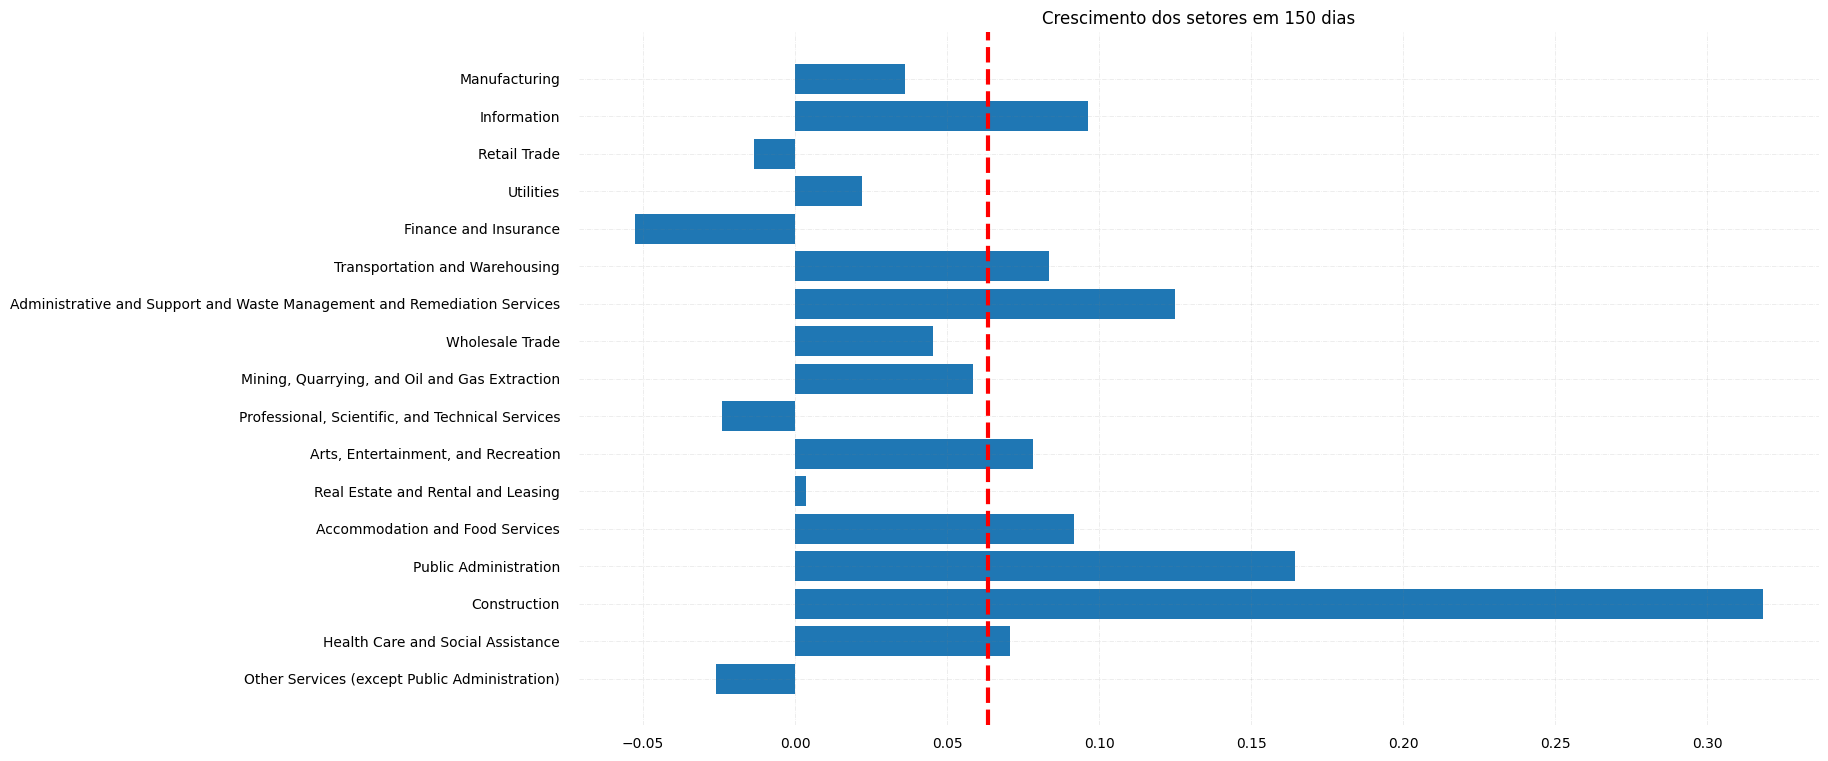

In [135]:
plotting(sectors_growth["Sectors"], sectors_growth["Growth-150days"], "150 dias")

Percebe-se que os setores que mais se destacam são o de Construção(5), Transporte(18), Atacado(15), portanto farei uma analise mais profunda em cada um desses setores, começando pela Construção

Pegando as 50 melhores ações de acordo com o método quantitativo escolhido.

In [136]:
rv_dataframe[rv_dataframe.isnull().any(axis=1)] # Lidando com valores NaN

,Ticker,Price,Number of Shares to Buy,Price-to-Earning Ratio,PE Percentile,Price-to-book Ratio,PB Percentile,Price-to-sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score,sector,2yearGrowth,1yearGrowth,150dayGrowth
23,GOOG,122.79,NaN,None,N/A,None,N/A,None,N/A,NaN,N/A,NaN,N/A,N/A,Information,-0.109029,0.134738,0.264573
26,AMCR,10.18,NaN,15.49,N/A,3.5,N/A,0.9964,N/A,10.382326,N/A,7.624346,N/A,N/A,None,-0.021857,-0.165454,-0.095006
42,AON,343.21,NaN,None,N/A,None,N/A,None,N/A,NaN,N/A,NaN,N/A,N/A,Finance and Insurance,0.498078,0.229842,0.09133
64,BRK.B,347.58,NaN,None,N/A,None,N/A,None,N/A,NaN,N/A,NaN,N/A,N/A,Finance and Insurance,0.248088,0.206917,0.122566
152,DIS,85.63,NaN,38.06,N/A,1.62,N/A,1.82,N/A,14.880540,N/A,6.832653,N/A,N/A,None,-0.513853,-0.166131,-0.21613
196,FRT,102.29,NaN,None,N/A,None,N/A,None,N/A,NaN,N/A,NaN,N/A,N/A,None,-0.048161,0.036802,-0.048334
208,FOX,30.98,NaN,None,N/A,None,N/A,None,N/A,NaN,N/A,NaN,N/A,N/A,Information,-0.06242,-0.036279,-0.091456
228,PEAK,22.01,NaN,21.79,N/A,1.83,N/A,5.79,N/A,10.138870,N/A,5.793458,N/A,N/A,None,-0.339679,-0.135537,-0.143062
265,J,126.21,NaN,None,N/A,None,N/A,None,N/A,NaN,N/A,NaN,N/A,N/A,"Professional, Scientific, and Technical Services",-0.043156,-0.022377,0.032513
275,KIM,20.60,NaN,None,N/A,None,N/A,None,N/A,NaN,N/A,NaN,N/A,N/A,None,0.068566,0.001404,-0.009422


In [137]:
for column in ['Price-to-Earning Ratio',
                'Price-to-book Ratio',
            'Price-to-sales Ratio', 'EV/EBITDA',
            'EV/GP']:
  rv_dataframe[column].fillna(rv_dataframe[column].mean(), inplace=True) ## os valores que forem NaN vão receber a media das outras métricas

In [138]:
from scipy.stats import percentileofscore as score

metricas = { ## dicionario
    'Price-to-Earning Ratio':'PE Percentile',
    'Price-to-book Ratio':'PB Percentile',
    'Price-to-sales Ratio':'PS Percentile',
    'EV/EBITDA':'EV/EBITDA Percentile',
    'EV/GP':'EV/GP Percentile',

}
for metric in metricas.keys(): ## percore pelas chaves do dicionario(price-to-earning  etc .. )
  for row in rv_dataframe.index: ## percore todas as linhas do data frame
    rv_dataframe.loc[row, metricas[metric]] = score(rv_dataframe[metric], rv_dataframe.loc[row, metric])
## para cada linha, entra na coluna dos percentiles e calcula o score
## score = porcentagem em comparação aos outros, ex: se o numero for maior que 80%
## dos outros valores da coluna, então recebe 80%



In [139]:
from statistics import mean

for row in rv_dataframe.index: ## percorre todas as linhas do tada frame
  value_percentiles = [] ## lista para pegar todas as procentagens da linha
  for metric in metricas.keys():
    value_percentiles.append(rv_dataframe.loc[row, metricas[metric]]) ## adicionando todas as porcentagens na lista


  rv_dataframe.loc[row, 'RV Score'] = mean(value_percentiles) ## rv score da linha = media das porcentagens

In [140]:
rv_dataframe.sort_values('RV Score', ascending=True, inplace=True) # ordenando o data frame pelo RV Score

In [141]:
rv_dataframe = rv_dataframe[(rv_dataframe['Price-to-Earning Ratio']>0) & (rv_dataframe['Price-to-book Ratio']>0) & (rv_dataframe['EV/EBITDA'] > 0) & (rv_dataframe['EV/GP'] > 0)]
#removendo valores negativos.
#removo esses valores pois evidenciam que a empresa não esta indo bem.
#A exemplo, se a price-to-earning for negativa, quer dizer que a empresa está com prejuízo.

In [142]:
top50_dataframe = rv_dataframe[:50] # pegando as 50 ações com menor score

In [143]:
rv_dataframe.reset_index(drop=True, inplace=True)

Construção:

In [144]:
construction_df = rv_dataframe[rv_dataframe["sector"] == "Construction"]

In [145]:
construction_df

,Ticker,Price,Number of Shares to Buy,Price-to-Earning Ratio,PE Percentile,Price-to-book Ratio,PB Percentile,Price-to-sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score,sector,2yearGrowth,1yearGrowth,150dayGrowth
35,PHM,83.42,NaN,7.19,13.8,1.89,28.6,1.05,16.0,5.079552,8.2,3.704419,25.6,18.44,Construction,0.58132,0.889437,0.477627
49,LEN,127.54,NaN,8.69,16.6,1.45,18.1,1.08,17.2,6.229672,11.0,5.708246,36.4,19.86,Construction,0.279233,0.586377,0.240147
62,DHI,131.00,NaN,8.82,17.0,2.14,33.2,1.32,23.3,6.827558,13.0,4.726280,30.8,23.46,Construction,0.429902,0.757154,0.323083
141,NVR,6361.13,NaN,13.38,24.6,5.26,66.2,1.95,36.9,8.603875,19.4,6.658344,45.6,38.54,Construction,0.239979,0.424719,0.232548
332,PWR,205.40,NaN,60.59,90.0,5.37,67.0,1.69,32.0,27.802928,88.0,13.113887,85.2,72.44,Construction,1.297841,0.539611,0.317867


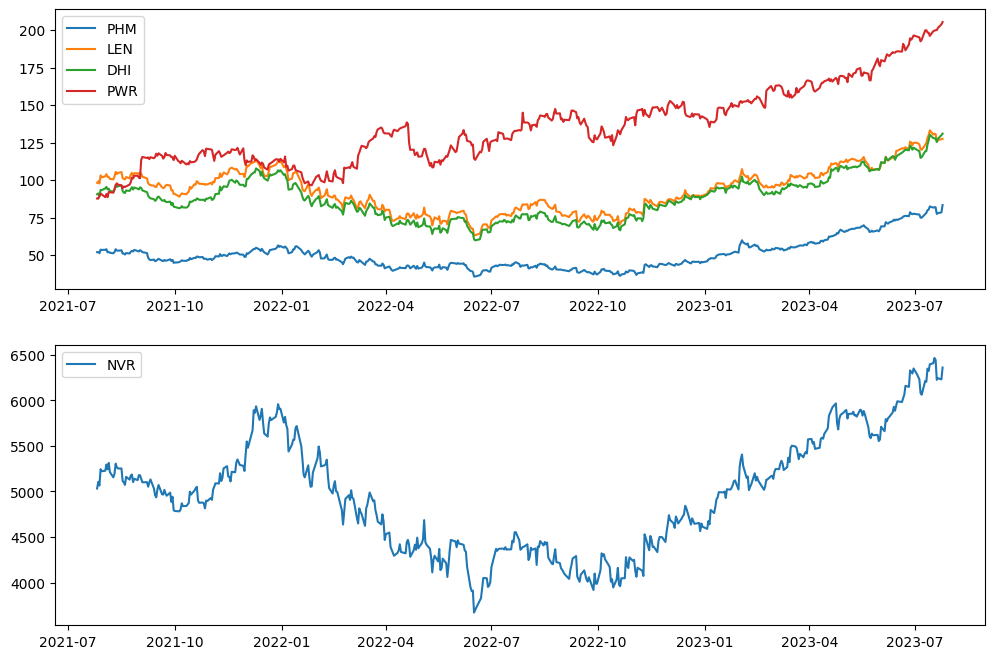

<Figure size 1200x1200 with 0 Axes>

In [146]:
Stocks_df = pd.DataFrame()


fig, axs = plt.subplots(2, figsize=(12,8))
plt.figure(figsize=(12,12))
for ind in construction_df.index:
  Ticker = construction_df["Ticker"][ind]
  if Ticker != "NVR":
    info = yf.Ticker(Ticker)
    hist = info.history(period="2y")["Close"]
    Stocks_df[f"{Ticker}"] = hist

    axs[0].plot(hist, label = f'{Ticker}')
    axs[0].legend()
    time.sleep(0.5)



info = yf.Ticker("NVR")
hist = info.history(period="2y")["Close"]
Stocks_df["NVR"] = hist
axs[1].plot(hist, label = "NVR")
axs[1].legend()

Estudando a correlação entre as ações

In [147]:
 corr_df =  Stocks_df.corr(method='pearson')
 #reset symbol as index (rather than 0-X)
 corr_df.head().reset_index()
 corr_df.head(10)

,PHM,LEN,DHI,PWR,NVR
PHM,1.000000,0.919007,0.944723,0.623368,0.923211
LEN,0.919007,1.000000,0.984397,0.427453,0.963397
DHI,0.944723,0.984397,1.000000,0.520884,0.957542
PWR,0.623368,0.427453,0.520884,1.000000,0.389781
NVR,0.923211,0.963397,0.957542,0.389781,1.000000


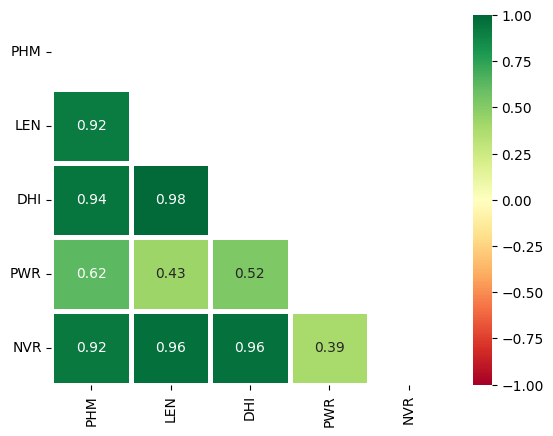

In [148]:
 #take the bottom triangle since it repeats itself
 mask = np.zeros_like(corr_df)
 mask[np.triu_indices_from(mask)] = True
 #generate plot
 sns.heatmap(corr_df, cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5, annot=True)
 plt.yticks(rotation=0)
 plt.xticks(rotation=90)
 plt.show()

Perceb-se a grande correlação entre as ações menos a Quanta Services, Inc. (PWR), isto devido ao crescimento maior comparado as outras ações

In [149]:
best_construction = top50_dataframe[top50_dataframe.sector == "Construction"]

In [150]:
best_construction

,Ticker,Price,Number of Shares to Buy,Price-to-Earning Ratio,PE Percentile,Price-to-book Ratio,PB Percentile,Price-to-sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score,sector,2yearGrowth,1yearGrowth,150dayGrowth
387,PHM,83.42,NaN,7.19,13.8,1.89,28.6,1.05,16.0,5.079552,8.2,3.704419,25.6,18.44,Construction,0.58132,0.889437,0.477627
286,LEN,127.54,NaN,8.69,16.6,1.45,18.1,1.08,17.2,6.229672,11.0,5.708246,36.4,19.86,Construction,0.279233,0.586377,0.240147


PHM, no rv_datframe esta entre as 50 melhores, está em um setor ótimo. Organizar melhor depois


Procurar - pq o crescimento da pwr é maior que o outros

Transporte


In [151]:
transportation_df = rv_dataframe[rv_dataframe["sector"] == "Transportation and Warehousing"]

In [152]:
transportation_df

,Ticker,Price,Number of Shares to Buy,Price-to-Earning Ratio,PE Percentile,Price-to-book Ratio,PB Percentile,Price-to-sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score,sector,2yearGrowth,1yearGrowth,150dayGrowth
11,UAL,54.22,NaN,6.74,13.0,2.39,38.9,0.3613,4.0,3.846649,4.4,0.587838,1.0,12.26,Transportation and Warehousing,0.140753,0.49202,0.086355
39,DAL,46.44,NaN,9.99,18.6,3.77,55.5,0.5480,6.6,6.176589,10.6,0.802169,2.8,18.82,Transportation and Warehousing,0.151634,0.481615,0.192659
54,FDX,259.66,NaN,16.73,33.8,2.49,40.0,0.7210,10.4,8.274409,18.8,0.873193,3.4,21.28,Transportation and Warehousing,-0.092365,0.164892,0.232516
89,LUV,35.53,NaN,34.83,74.8,2.15,33.7,0.8917,13.4,8.125535,18.0,0.744933,2.2,28.42,Transportation and Warehousing,-0.288079,-0.111414,0.005296
90,ALK,48.18,NaN,104.76,96.4,1.85,27.8,0.6713,8.8,6.021914,10.0,0.635320,1.2,28.84,Transportation and Warehousing,-0.172876,0.101509,-0.041575
101,UPS,184.69,NaN,14.93,28.8,6.81,75.5,1.3800,23.9,9.544496,23.2,1.509784,8.4,31.96,Transportation and Warehousing,-0.072368,0.017981,0.00678
106,KMI,18.06,NaN,15.98,32.0,1.31,16.2,2.1500,42.0,9.907374,24.4,6.991102,49.4,32.8,Transportation and Warehousing,0.176899,0.066952,0.009345
117,EXPD,125.45,NaN,16.31,32.9,6.07,71.4,1.2700,21.9,9.861419,24.2,3.968707,27.4,35.56,Transportation and Warehousing,-0.015679,0.280311,0.111267
128,JBHT,199.76,NaN,22.70,51.4,5.41,68.0,1.4100,24.7,11.173094,29.8,1.597012,9.2,36.62,Transportation and Warehousing,0.214703,0.163131,0.040729
149,TRGP,81.67,NaN,21.16,46.6,7.21,76.8,0.8976,13.8,8.711689,20.0,6.332701,42.4,39.92,Transportation and Warehousing,0.992635,0.301215,0.074807


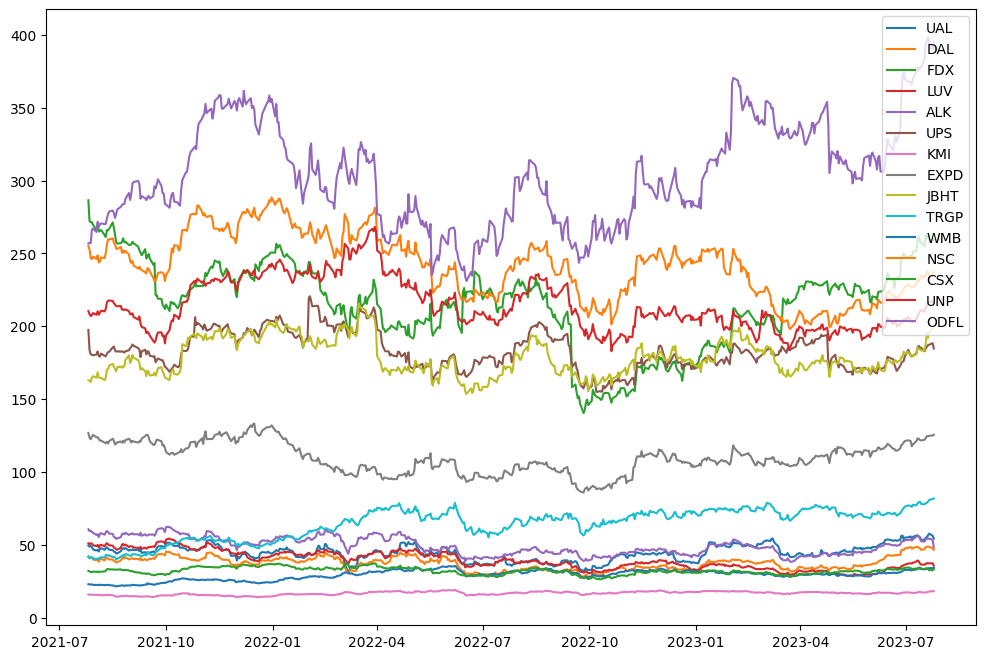

In [153]:
Stocks_df = pd.DataFrame()


plt.figure(figsize=(12,8))
for ind in transportation_df.index:
  Ticker = transportation_df["Ticker"][ind]
  if Ticker != "NVR":
    info = yf.Ticker(Ticker)
    hist = info.history(period="2y")["Close"]
    Stocks_df[f"{Ticker}"] = hist
    plt.plot(hist, label = f'{Ticker}')
    plt.legend()
    time.sleep(0.5)


In [ ]:
 corr_df =  Stocks_df.corr(method='pearson')
 #reset symbol as index (rather than 0-X)
 corr_df.head().reset_index()
 corr_df.head(10)

In [ ]:
 #take the bottom triangle since it repeats itself
 mask = np.zeros_like(corr_df)
 mask[np.triu_indices_from(mask)] = True
 #generate plot
 plt.figure(figsize=(12,8))
 sns.heatmap(corr_df, cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5, annot=True)

 plt.yticks(rotation=0)
 plt.xticks(rotation=90)
 plt.show()

Percebe-se que KMI, TRGP, WMB tem um correlação negativa a quase todas as outras empresas no ramo

In [156]:
best_transportation = top50_dataframe[top50_dataframe.sector == "Transportation and Warehousing"]

In [157]:
best_transportation

,Ticker,Price,Number of Shares to Buy,Price-to-Earning Ratio,PE Percentile,Price-to-book Ratio,PB Percentile,Price-to-sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score,sector,2yearGrowth,1yearGrowth,150dayGrowth
459,UAL,54.22,NaN,6.74,13.0,2.39,38.9,0.3613,4.0,3.846649,4.4,0.587838,1.0,12.26,Transportation and Warehousing,0.140753,0.49202,0.086355
144,DAL,46.44,NaN,9.99,18.6,3.77,55.5,0.5480,6.6,6.176589,10.6,0.802169,2.8,18.82,Transportation and Warehousing,0.151634,0.481615,0.192659


Temos que a UAL e DAL são as empresas com melhores scores no nosso método, portanto aprofundsarei a pesquisa nessas duas

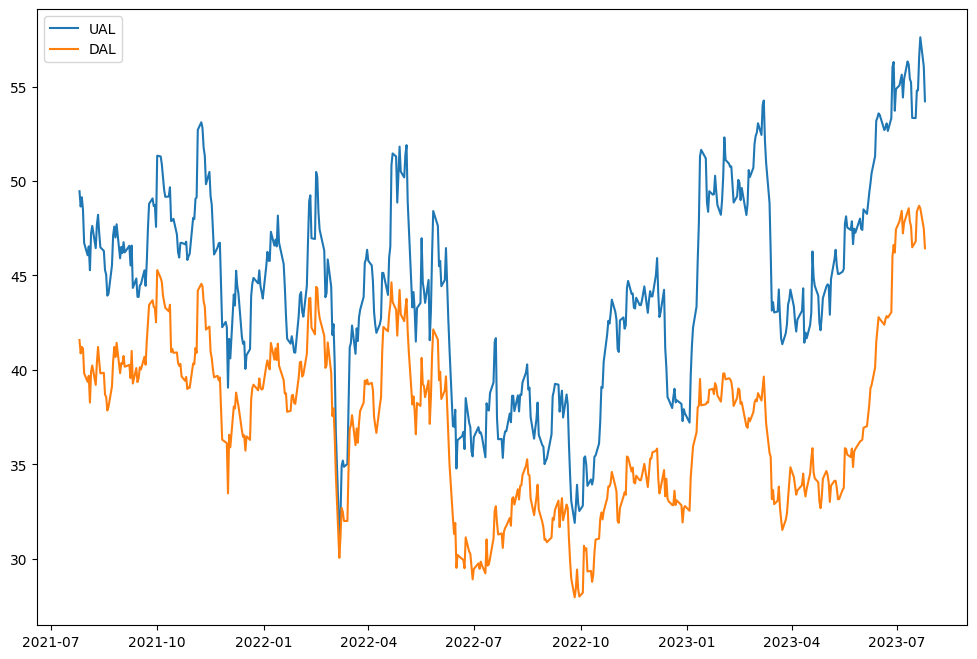

In [158]:
plt.figure(figsize=(12,8))
for ind in best_transportation.index:
  Ticker = best_transportation["Ticker"][ind]
  info = yf.Ticker(Ticker)
  hist = info.history(period="2y")["Close"]
  Stocks_df[f"{Ticker}"] = hist
  plt.plot(hist, label = f'{Ticker}')
  plt.legend()
  time.sleep(0.5)

Percebe-se a grande correlação entre as duas ações, movimentos praticamente iguais

Comprar 50% de cada

In [159]:
wholesale = rv_dataframe[rv_dataframe.sector == "Wholesale Trade"]

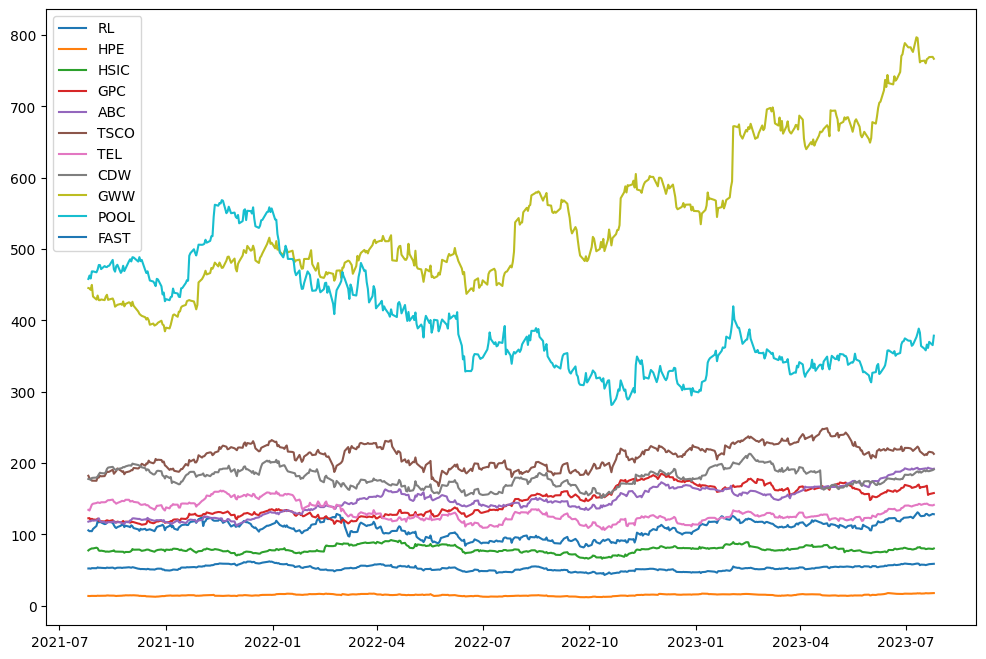

In [160]:
Stocks_df = pd.DataFrame()


plt.figure(figsize=(12,8))
for ind in wholesale.index:
  Ticker = wholesale["Ticker"][ind]
  if Ticker != "CMG":
    info = yf.Ticker(Ticker)
    hist = info.history(period="2y")["Close"]
    Stocks_df[f"{Ticker}"] = hist
    plt.plot(hist, label = f'{Ticker}')
    plt.legend()
    time.sleep(0.5)


In [ ]:
 corr_df =  Stocks_df.corr(method='pearson')
 #reset symbol as index (rather than 0-X)
 corr_df.head().reset_index()
 corr_df.head(10)

In [ ]:
 #take the bottom triangle since it repeats itself
 mask = np.zeros_like(corr_df)
 mask[np.triu_indices_from(mask)] = True
 #generate plot
 plt.figure(figsize=(12,8))
 sns.heatmap(corr_df, cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5, annot=True)

 plt.yticks(rotation=0)
 plt.xticks(rotation=90)
 plt.show()

percebe-se tambem a grande correlacao entre as empresas, tirando a TEL e a POOL

In [ ]:
best_wholesale = top50_dataframe[top50_dataframe.sector == "Wholesale Trade"]

In [ ]:
best_wholesale

Investimento na Ralph Lauren

Portanto, o portifólio final ficará - 30% ralph lauren 20%- delta 20%- UAL 30%- PHM

O preço de cada uma no final do dia 25 é o seguinte:

Ralph Lauren(RL) - 128.15

Delta(DAL) - 46.44

United Airlines(UAL) - 54.22

PulteGroup(PHM) - 84.42


In [165]:
## estudar a correlação entre as acções

In [166]:
rv_dataframe[rv_dataframe.isnull().any(axis=1)] # Lidando com valores NaN

,Ticker,Price,Number of Shares to Buy,Price-to-Earning Ratio,PE Percentile,Price-to-book Ratio,PB Percentile,Price-to-sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score,sector,2yearGrowth,1yearGrowth,150dayGrowth
122,AMCR,10.18,NaN,15.490000,30.4,3.500000,52.8,0.996400,15.0,10.382326,26.2,7.624346,54.6,35.8,None,-0.021857,-0.165454,-0.095006
169,PEAK,22.01,NaN,21.790000,48.6,1.830000,27.3,5.790000,80.0,10.138870,25.2,5.793458,37.8,43.78,None,-0.339679,-0.135537,-0.143062
193,DIS,85.63,NaN,38.060000,77.8,1.620000,22.7,1.820000,34.2,14.880540,52.0,6.832653,47.2,46.78,None,-0.513853,-0.166131,-0.21613
310,WELL,82.94,NaN,376.320000,98.8,2.010000,30.8,6.820000,83.8,27.279446,87.6,6.851448,47.6,69.72,None,0.004668,0.018627,0.11291
345,KIM,20.60,NaN,100.854797,95.5,9.024685,82.1,3.934416,65.7,17.658916,63.3,8.825759,63.7,74.06,None,0.068566,0.001404,-0.009422
346,FRT,102.29,NaN,100.854797,95.5,9.024685,82.1,3.934416,65.7,17.658916,63.3,8.825759,63.7,74.06,None,-0.048161,0.036802,-0.048334
359,LIN,391.04,NaN,43.550000,82.4,4.720000,62.6,5.660000,79.0,18.167712,67.2,14.193565,87.0,75.64,None,0.347663,0.37784,0.184631


In [167]:
for column in ['Price-to-Earning Ratio',
                'Price-to-book Ratio',
            'Price-to-sales Ratio', 'EV/EBITDA',
            'EV/GP']:
  rv_dataframe[column].fillna(rv_dataframe[column].mean(), inplace=True) ## os valores que forem NaN vão receber a media das outras métricas

<ipython-input-167-825d5252f162>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe[column].fillna(rv_dataframe[column].mean(), inplace=True) ## os valores que forem NaN vão receber a media das outras métricas


In [168]:
rv_dataframe[rv_dataframe.isnull().any(axis=1)] # não existe mais valores Nan

,Ticker,Price,Number of Shares to Buy,Price-to-Earning Ratio,PE Percentile,Price-to-book Ratio,PB Percentile,Price-to-sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score,sector,2yearGrowth,1yearGrowth,150dayGrowth
122,AMCR,10.18,NaN,15.490000,30.4,3.500000,52.8,0.996400,15.0,10.382326,26.2,7.624346,54.6,35.8,None,-0.021857,-0.165454,-0.095006
169,PEAK,22.01,NaN,21.790000,48.6,1.830000,27.3,5.790000,80.0,10.138870,25.2,5.793458,37.8,43.78,None,-0.339679,-0.135537,-0.143062
193,DIS,85.63,NaN,38.060000,77.8,1.620000,22.7,1.820000,34.2,14.880540,52.0,6.832653,47.2,46.78,None,-0.513853,-0.166131,-0.21613
310,WELL,82.94,NaN,376.320000,98.8,2.010000,30.8,6.820000,83.8,27.279446,87.6,6.851448,47.6,69.72,None,0.004668,0.018627,0.11291
345,KIM,20.60,NaN,100.854797,95.5,9.024685,82.1,3.934416,65.7,17.658916,63.3,8.825759,63.7,74.06,None,0.068566,0.001404,-0.009422
346,FRT,102.29,NaN,100.854797,95.5,9.024685,82.1,3.934416,65.7,17.658916,63.3,8.825759,63.7,74.06,None,-0.048161,0.036802,-0.048334
359,LIN,391.04,NaN,43.550000,82.4,4.720000,62.6,5.660000,79.0,18.167712,67.2,14.193565,87.0,75.64,None,0.347663,0.37784,0.184631


Calculando as Porcentagens


In [169]:
from scipy.stats import percentileofscore as score

metricas = { ## dicionario
    'Price-to-Earning Ratio':'PE Percentile',
    'Price-to-book Ratio':'PB Percentile',
    'Price-to-sales Ratio':'PS Percentile',
    'EV/EBITDA':'EV/EBITDA Percentile',
    'EV/GP':'EV/GP Percentile',

}
for metric in metricas.keys(): ## percore pelas chaves do dicionario(price-to-earning  etc .. )
  for row in rv_dataframe.index: ## percore todas as linhas do data frame
    rv_dataframe.loc[row, metricas[metric]] = score(rv_dataframe[metric], rv_dataframe.loc[row, metric])
## para cada linha, entra na coluna dos percentiles e calcula o score
## score = porcentagem em comparação aos outros, ex: se o numero for maior que 80%
## dos outros valores da coluna, então recebe 80%



Calculando o rv score

In [ ]:
from statistics import mean

for row in rv_dataframe.index: ## percorre todas as linhas do tada frame
  value_percentiles = [] ## lista para pegar todas as procentagens da linha
  for metric in metricas.keys():
    value_percentiles.append(rv_dataframe.loc[row, metricas[metric]]) ## adicionando todas as porcentagens na lista


  rv_dataframe.loc[row, 'RV Score'] = mean(value_percentiles) ## rv score da linha = media das porcentagens

Selecionando as 50 melhores ações

In [171]:
rv_dataframe.sort_values('RV Score', ascending=True, inplace=True) # ordenando o data frame pelo RV Score

<ipython-input-171-d427127a4e1a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_dataframe.sort_values('RV Score', ascending=True, inplace=True) # ordenando o data frame pelo RV Score


In [172]:
rv_dataframe = rv_dataframe[(rv_dataframe['Price-to-Earning Ratio']>0) & (rv_dataframe['Price-to-book Ratio']>0) & (rv_dataframe['EV/EBITDA'] > 0) & (rv_dataframe['EV/GP'] > 0)]
#removendo valores negativos.
#removo esses valores pois evidenciam que a empresa não esta indo bem.
#A exemplo, se a price-to-earning for negativa, quer dizer que a empresa está com prejuízo.

In [173]:
rv_dataframe = rv_dataframe[:50] # pegando as 50 ações com menor score

In [174]:
rv_dataframe.reset_index(drop=True, inplace=True)

Numero de ações para comprar

In [175]:
def portfolio_input():
  global portfolio_size
  portfolio_size = input('Digite o vlaor do Investimento: ')

  try:
    val = float(portfolio_size)

  except ValueError:
    print('Digite em formato de numeral!')
    portfolio_size = float(input("Digite o valor de Investimento: "))

#função para receber o valor a ser investido

In [176]:
portfolio_input() # para o exemplo vou usar 1.000.000

KeyboardInterrupt: ignored

In [ ]:
position_size = float(portfolio_size)/len(rv_dataframe.index)
position_size

In [ ]:
for row in rv_dataframe.index: ## calculando a quantidade de funções para comprar de cada empresa e colocando no dataframe
  rv_dataframe.loc[row, 'Number of Shares to Buy'] = math.floor(position_size/rv_dataframe.loc[row, 'Price'])

In [ ]:
rv_dataframe # dataframe final

Transformando esses dados em um excel para futuras pesquisas


In [ ]:
writer = pd.ExcelWriter('value_strategy.xlsx', engine='xlsxwriter')
rv_dataframe.to_excel(writer, sheet_name ='Compras', index=False)
writer.save()

Estudo de algumas das empresas melhores colocadas para os investimentos:

A empresa melhor colocada, First Republic Bank, é uma empresa bancária da Califórnia, quais ações cairam 90% nos ultimos 6 meses


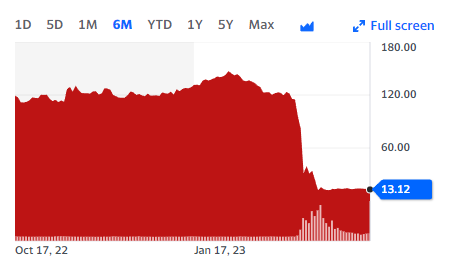

Fazendo um estudo do top 10, percebe-se que 8 empresas são do ramo financeiro, bancário ou de seguros. Isso devido ao cenário atual da economia americana, em que vários bancos estão quebrando e portanto, está ocorrendo a desvalorização de muitos deles, a exemplo de um banco que quebrou, o Silicon Valley Bank

Além disso, percebe-se que 9 de todas as ações no top 10 estão em queda nos ultimos 6 meses, evidenciando que os modelos matemáticos utilizados para fazer o estudo quantitativo "procuram" empresas subvalorizadas. Exemplos:


Synchrony Financial (SYF):




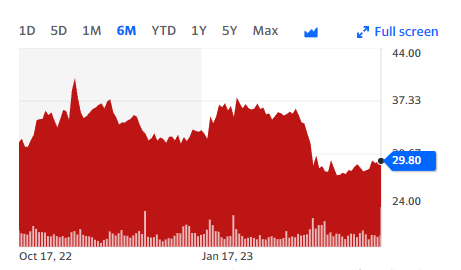




Principal Financial Group, Inc. (PFG):



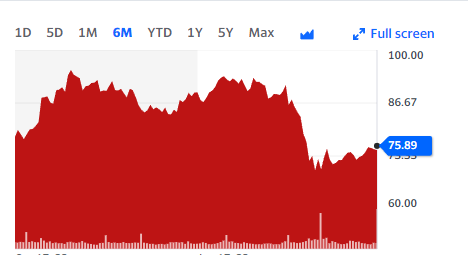

Perceb-se que todas possuem uma grande queda nos dias 10-12 de março de 2023. Sendo o dia 10, o dia em que o Silicon Valley Bank colapsou

Estudo feito no dia 15/04


Estudo continuará após um mês para verificar os ganhos ou perdas nas ações nessa situação hipotética de investimento

Dia 18/04, mudanças na porcentagem de cada ação após 3 dias



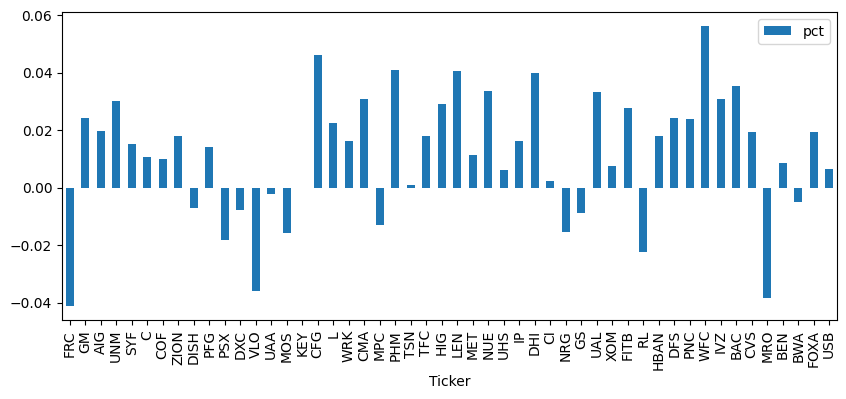

[1917682.62, 2048680.71, 2039644.8, 2059933.2599999998, 2030198.5, 2020978.4, 2020065.4, 2036030.73, 1985969.07, 2028258.645, 1963218.51, 1984324.72, 1927877.3699999999, 1995639.59, 1968066.8800000001, 1999988.25, 2092080.32, 2045113.1099999999, 2032470.2300000002, 2061876.96, 1973585.52, 2081430.4500000002, 2001588.21, 2036077.5, 2057873.9400000002, 2080884.75, 2022739.52, 2066774.4000000001, 2012054.4000000001, 2032274.06, 2079976.08, 2004547.1099999999, 1968757.3199999998, 1982089.7600000002, 2066227.7999999998, 2015227.02, 2055193.1400000001, 1954748.16, 2035923.6600000001, 2048557.8399999999, 2047685.8800000001, 2112508.98, 2061570.33, 2070440.0, 2038496.22, 1923040.2, 2017186.68, 1989716.16, 2038899.7200000002, 2012551.2899999998] --- total
101146724.175

In [ ]:
##### codigo extra para análise

In [ ]:
#dia 18/04
stocks_escolhidas = pd.read_excel('value_strategy.xlsx') ## pegando os tickers escolhidos pelo estudo qualitativo

amount_each_stock = []

for row in stocks_escolhidas.index:
  amount_each_stock.append(stocks_escolhidas.loc[row, 'Number of Shares to Buy'] * stocks_escolhidas.loc[row, 'Price'])


tickers = stocks_escolhidas['Ticker']
tickers = tickers.tolist()

ticker_string = ','.join(tickers)

In [ ]:
IEX_CLOUD_API_TOKEN = '#####'

rv_columns= [ ## nome das colunas
    'Ticker',
    'Price',
    'Number of Shares to Buy',
    'Price-to-Earning Ratio',
    'PE Percentile',
    'Price-to-book Ratio',
    'PB Percentile',
    'Price-to-sales Ratio',
    'PS Percentile',
    'EV/EBITDA',
    'EV/EBITDA Percentile',
    'EV/GP',
    'EV/GP Percentile',
    'RV Score'
]

analysis_df = pd.DataFrame(columns = rv_columns)

In [ ]:
batch_api = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={ticker_string}&types=quote,advanced-stats&token={IEX_CLOUD_API_TOKEN}'
data = requests.get(batch_api).json() #obtendo as estatisticas das 100 ações pelo api da IEX CLOUD
print(data.keys())


In [ ]:
  for ticker in tickers: ## percore cada ticker
    enterprise_value = data[ticker]['advanced-stats']['enterpriseValue'] # obtendo valores
    ebitda =  data[ticker]['advanced-stats']['EBITDA']
    gross_profit = data[ticker]['advanced-stats']['grossProfit']

    try:
      ev_to_ebitda = enterprise_value/ebitda
    except TypeError:
      ev_to_ebitda = np.NaN

# fazendo esses trys e excepts pois algumas empresas não divulgam tais informações.
# o problema com os valores nulos sera resolvido mais a frente

    try:
      ev_to_gross_profit = enterprise_value/gross_profit
    except TypeError:
      ev_to_gross_profit = np.NaN


    analysis_df = analysis_df.append( ## adicionando as informações no dataframe
        pd.Series([
                ticker,
                data[ticker]['quote']['latestPrice'],
                'NaN',
                data[ticker]['quote']['peRatio'],
                'N/A',
                data[ticker]['advanced-stats']['priceToBook'],
                'N/A',
                data[ticker]['advanced-stats']['priceToSales'],
                'N/A',
                ev_to_ebitda,
                'N/A',
                ev_to_gross_profit,
                'N/A',
                'N/A'


        ],
        index= rv_columns),
          ignore_index = True
    )


In [ ]:
for column in ['Price-to-Earning Ratio',
                'Price-to-book Ratio',
            'Price-to-sales Ratio', 'EV/EBITDA',
            'EV/GP']:
  analysis_df[column].fillna(analysis_df[column].mean(), inplace=True) ## os valores que forem NaN vão receber a media das outras métricas

In [ ]:
from scipy.stats import percentileofscore as score

metricas = { ## dicionario
    'Price-to-Earning Ratio':'PE Percentile',
    'Price-to-book Ratio':'PB Percentile',
    'Price-to-sales Ratio':'PS Percentile',
    'EV/EBITDA':'EV/EBITDA Percentile',
    'EV/GP':'EV/GP Percentile',

}
for metric in metricas.keys(): ## percore pelas chaves do dicionario(price-to-earning  etc .. )
  for row in analysis_df.index: ## percore todas as linhas do data frame
    analysis_df.loc[row, metricas[metric]] = score(analysis_df[metric], analysis_df.loc[row, metric])
## para cada linha, entra na coluna dos percentiles e calcula o score
## score = porcentagem em comparação aos outros, ex: se o numero for maior que 80%
## dos outros valores da coluna, então recebe 80%



In [ ]:
from statistics import mean

for row in analysis_df.index: ## percorre todas as linhas do tada frame
  value_percentiles = [] ## lista para pegar todas as procentagens da linha
  for metric in metricas.keys():
    value_percentiles.append(analysis_df.loc[row, metricas[metric]]) ## adicionando todas as porcentagens na lista


  analysis_df.loc[row, 'RV Score'] = mean(value_percentiles) ## rv score da linha = media das porcentagens

In [ ]:
analysis_df['Number of Shares to Buy'] = stocks_escolhidas['Number of Shares to Buy']

In [ ]:
total = 0
stocks_total_analysis = []


for row in analysis_df.index:
  stocks_total_analysis.append(analysis_df.loc[row, 'Number of Shares to Buy'] * analysis_df.loc[row, 'Price'])


total = sum(stocks_total_analysis)
print(total)



In [ ]:
print(stocks_total_analysis)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
pct_changes = []

for i in range(len(stocks_total_analysis)):
  pct_changes.append(stocks_total_analysis[i] / amount_each_stock[i]- 1)


test = pd.DataFrame()
test['Ticker'] = tickers
test['pct'] = pct_changes

test

In [ ]:
test.plot.bar(x='Ticker',
              figsize=(10,4))